In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

/home/apk/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
eeg=h5py.File("ME_2_R_2019.01.04_12.46.47.hdf5",mode='r')
keys2= list(eeg.keys())
print keys2
keys1= list(eeg[keys2[0]].keys())
print keys1
#print eeg[keys2[0]][keys1[0]]
#eeg["RawData"]['Samples']
print list(eeg['RawData'].keys())
print eeg['RawData']['Samples']
sampletime = np.array(eeg['AsynchronData']["Time"])
time=sampletime/256.0
print sampletime

[u'AsynchronData', u'RawData', u'SavedFeatues', u'Version']
[u'AsynchronSignalTypes', u'Time', u'TypeID', u'Value']
[u'AcquisitionTaskDescription', u'DAQDeviceCapabilities', u'DAQDeviceDescription', u'Samples', u'SessionDescription', u'SubjectDescription']
<HDF5 dataset "Samples": shape (20625, 64), type "<f4">
[[ 8461]
 [ 8986]
 [11476]
 [13931]
 [16031]
 [18081]
 [20076]]


In [4]:
samples=np.array(eeg["RawData"]['Samples'])
samples=samples.T

In [6]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples)-samples[i])/63.0)
    
    sample=samples-s
    return sample, s

In [7]:
import scipy.signal as signal
def butter_bandpass(lowcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    
    b, a = signal.butter(order, low, btype='high')
    return b, a

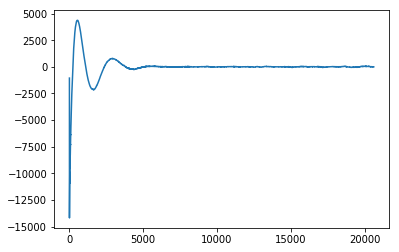

In [8]:
sample, s= CAR(samples)
#b, a=butter_bandpass(1,256, 8)
#sample[10]=signal.filtfilt( b, a, sample[10], padlen=0)
plt.plot(np.arange(len(samples[10])) ,sample[10])
#print sample[10]

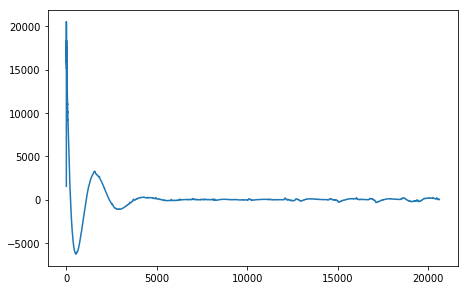

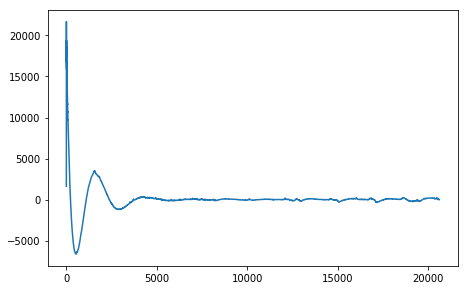

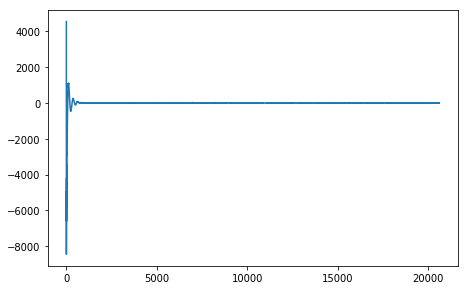

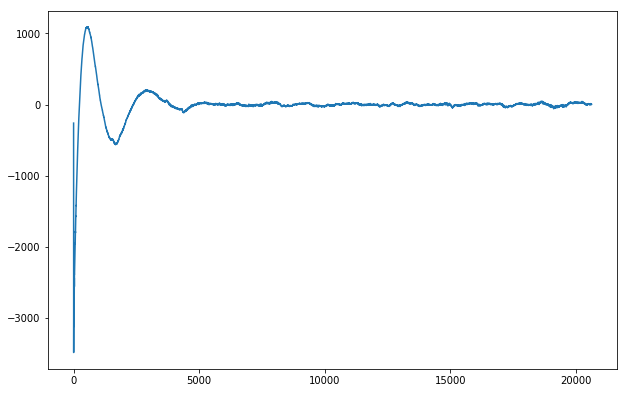

In [68]:
plt.rcParams["figure.figsize"] = [25,16]
fig = plt.figure()
plot=fig.add_subplot(3,3,1)
plt.plot(np.arange(len(sample[1])), sample[1])

fig = plt.figure()
plot=fig.add_subplot(3,3,2)
plt.plot(np.arange(len(sample[1])), sample[2])

fig = plt.figure()
plot=fig.add_subplot(3,3,3)
plt.plot(np.arange(len(sample[1])), sample[10])

fig = plt.figure()
plot=fig.add_subplot(3,3,4)
plt.plot(np.arange(len(sample[1])), sample[11])

plt.tight_layout()
plt.show()

In [9]:
####
##Baseline Correction
#Assymmetric Least squares smoothing
##https://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
#generally 0.001≤p≤0.1,    102≤λ≤109(10 to power 9)
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [10]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

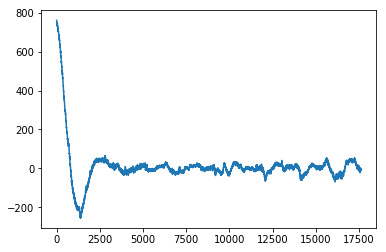

In [14]:
#sample[10]=signal.detrend(sample[10])
z= baseline_als(sample[10], 10**4, 0.1, 10)
plt.plot(np.arange(len(samples[10][3000:])) ,signal.detrend(sample[10])[3000:])

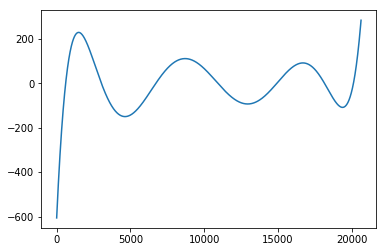

In [23]:
data=sample[10]
order=7
x= np.arange(len(data))
fit= np.polyval(np.polyfit(x, data, deg=order), x) ##polynomial curve fitting
plt.plot(np.arange(len(data-fit)) ,fit)